## Comparing CEDS and SNEII inventories in OsloCTM3
### AOD and aerosol RF

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
#import xesmf as xe
from matplotlib import rcParams
import pandas as pd
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import cftime

In [8]:
#define file locations
file_loc1 = '/div/pdo/mariantl/QUISARC/osloctm3_newIndEmis/dta2nc/'
file_loc2 = '/div/amoc/d3/aerocom/phase2/genout/data_eclv6/'

#***change filename here***
filename1 = 'CEDS21_OsloCTM3v1.02-met2010_od550aer_Column_2018_monthly.nc'
filename2 = 'India_OsloCTM3v1.02-met2010_od550aer_Column_2018_monthly.nc'

outfile = '/div/nac/users/zofias/plots/SNEII/'

In [38]:
rcParams['font.size'] = 16

### Import data

In [39]:
#import data
ds_ceds = xr.open_dataset(f'{file_loc2}{filename1}',decode_times=False)
ds_sneii = xr.open_dataset(f'{file_loc2}{filename2}',decode_times=False)

In [40]:
ds_ceds

<xarray.Dataset>
Dimensions:    (lon: 160, lat: 80, time: 12, bnds: 2)
Coordinates:
  * lon        (lon) float32 0.0 2.25 4.5 6.75 9.0 ... 351.0 353.2 355.5 357.8
  * lat        (lat) float32 -88.88 -86.62 -84.38 -82.12 ... 84.38 86.62 88.88
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float32 ...
    lat_bnds   (lat, bnds) float32 ...
    time_bnds  (time, bnds) float32 ...
    od550aer   (time, lat, lon) float32 ...
Attributes:
    title:          Output from OsloCTM3 with Eclipse v6 emissions
    institution:    CICERO
    Modelinfo1:     OsloCTM3 is a 3D Chemical Transport Model
    Modelinfo2:     It is driven by ECMWF meteorological data
    contactinfo:    gunnar.myhre@cicero.oslo.no
    references:     Lund et al., 2018 (GMD, 11, 4909-4931) &      Myhre et al...
    creation_date:  Mon Oct  4 16:18:48 2021

### Calculations: averaging, surface conc, column

In [41]:
calcs = {
    "CEDS": xr.Dataset(),
    "SNEII": xr.Dataset()
}

models = {
    "CEDS": ds_ceds,
    "SNEII": ds_sneii
}

model_list = ["CEDS", "SNEII"]

In [42]:
# define constants
mr_o3 = 48
mr_air_kg = 28.97e-3
mr_air = 28.97
n_a = 6.022e23
molec_per_du = 2.69e20

In [43]:
#calculate tropospheric O3 by masking below 150 ppb
#calculate ozone in DU
for exp in model_list:
    exp_ukca = models[exp]
    exp_calc = calcs[exp]
    #print(exp_ukca)
    #print(exp_ukca[")
    
    exp_calc["AOD"] = (
        exp_ukca.od550aer
        .load()
    )

### Radiative calculations

In [44]:
# RF filenames
# direct RF
direct_ceds = 'CEDS21_OsloCTM3v1.02-met2010_rsut_Surface_2018_monthly.nc'
direct_sneii = 'India_OsloCTM3v1.02-met2010_rsut_Surface_2018_monthly.nc'

indirect_ceds='CEDS21_OsloCTM3v1.01_indir-met2010_rsut_Surface_2018_monthly.nc'
indirect_sneii='India_OsloCTM3v1.01_indir-met2010_rsut_Surface_2018_monthly.nc' 

rf_direct_ceds = xr.open_dataset(f'{file_loc2}{direct_ceds}',decode_times=False)
rf_indirect_ceds =xr.open_dataset(f'{file_loc2}{indirect_ceds}',decode_times=False)

rf_direct_sneii = xr.open_dataset(f'{file_loc2}{direct_sneii}',decode_times=False)
rf_indirect_sneii = xr.open_dataset(f'{file_loc2}{indirect_sneii}',decode_times=False)

In [45]:
rf_direct_sneii

<xarray.Dataset>
Dimensions:    (lon: 160, lat: 80, time: 12, bnds: 2)
Coordinates:
  * lon        (lon) float32 0.0 2.25 4.5 6.75 9.0 ... 351.0 353.2 355.5 357.8
  * lat        (lat) float32 -88.88 -86.62 -84.38 -82.12 ... 84.38 86.62 88.88
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float32 ...
    lat_bnds   (lat, bnds) float32 ...
    time_bnds  (time, bnds) float32 ...
    rsut       (time, lat, lon) float32 ...
Attributes:
    title:          Output from OsloCTM3 with Eclipse v6 emissions
    institution:    CICERO
    Modelinfo1:     OsloCTM3 is a 3D Chemical Transport Model
    Modelinfo2:     It is driven by ECMWF meteorological data
    contactinfo:    gunnar.myhre@cicero.oslo.no
    references:     Lund et al., 2018 (GMD, 11, 4909-4931) &      Myhre et al...
    creation_date:  Mon May 30 17:00:39 2022

In [53]:
# calculate net RF from individual components, W m-2
calcs['CEDS']["net_RF"] = (rf_direct_ceds["rsut"] + rf_indirect_ceds["rsut"]) *-1.
calcs['SNEII']["net_RF"] = (rf_direct_sneii["rsut"] + rf_indirect_sneii["rsut"]) *-1.

In [54]:
calcs['diff'] = calcs['SNEII'] - calcs['CEDS']

### Plots

In [55]:
city_names = ['Mumbai','Delhi','Kolkata','Chennai','Bengalūru','Hyderabad']
city_lat_lons = np.array([[72.836447, 18.987807],[77.231495, 28.651952], [88.363044, 22.562627],[80.248357, 13.084622],[77.587106, 12.977063],[78.456355, 17.384052]])

In [56]:
cmap_ol_pu_bk = LinearSegmentedColormap.from_list('Random gradient 442', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%20442=0:FFFFFF-25:B6B610-60:7A7AF3-100:000000
    (0.000, (1.000, 1.000, 1.000)),
    (0.250, (0.714, 0.714, 0.063)),
    (0.600, (0.478, 0.478, 0.953)),
    (1.000, (0.000, 0.000, 0.000))))

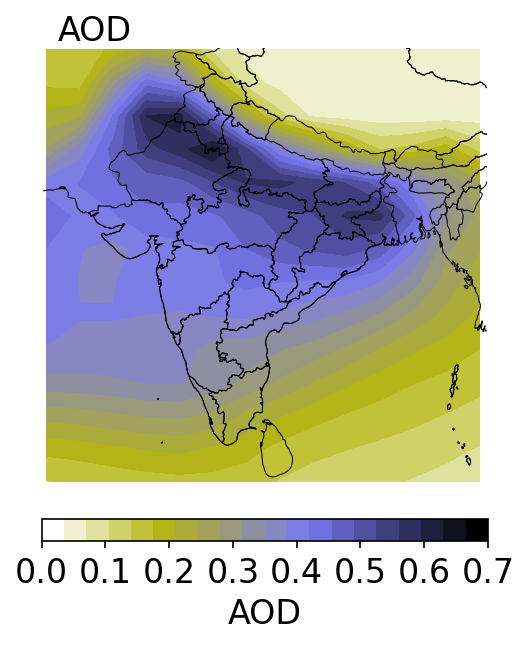

In [57]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['SNEII'].AOD.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(cmap=cmap_ol_pu_bk,
    vmax=0.7, vmin=0,
    levels=21, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'AOD',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(0,0.71,0.1))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
plt.text(66,35.5,f'AOD')
#ax.scatter(city_lat_lons[:,0],city_lat_lons[:,1],marker='o',facecolors='none',edgecolors='deeppink',zorder=10,s=10)
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())
#plt.title(f"SNEII - CEDS")
#plt.savefig(f'{outfile}SNEII_o3_trop_col_map_land_masked.pdf',format='pdf',bbox_inches='tight')

(65.0, 95.0, 5.0, 35.0)

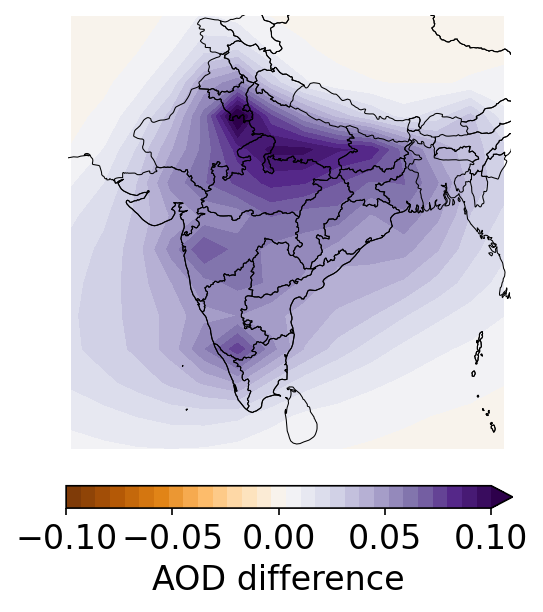

In [58]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['diff'].AOD.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(cmap="PuOr",
    vmax=0.1, vmin=-0.1,
    levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'AOD difference',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(-0.1,0.11,0.05))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure
#plt.savefig(f'{outfile}SNEII_CEDS_diff_o3_trop_col_map_land_masked.pdf',format='pdf',bbox_inches='tight')
#plt.title(f"SNEII - CEDS")

(65.0, 95.0, 5.0, 35.0)

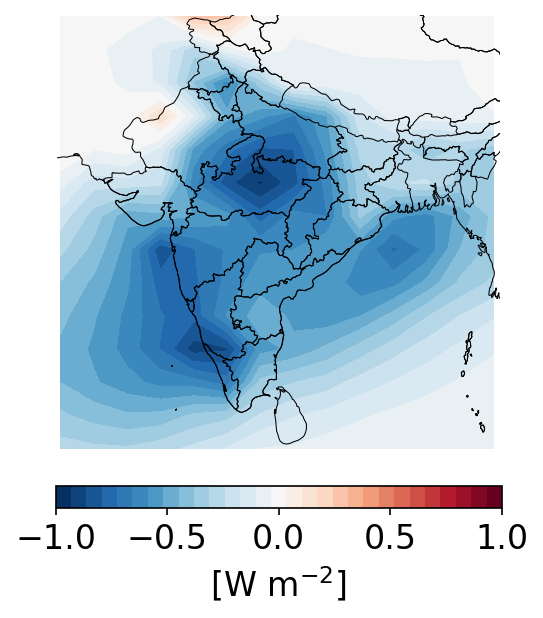

In [59]:
fig, ax = plt.subplots(1, 1, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()))
fg = calcs['diff'].net_RF.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(cmap="RdBu_r",
    vmax=1, vmin=-1,
    levels=30, 
    #cbar_kwargs={'label': f'[ppb]','location':'bottom','pad': 0.05,'shrink':0.6,'ticks':np.arange(-8,9,2)},
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[W m$^{{-2}}$]',location='bottom',pad= 0.05,shrink=0.6,ticks=np.arange(-1,1.1,0.5))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
#colobar().ax.tick_params(axis='y', direction='in')
#ax.colorbar(location='bottom')
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')

ax.axis("off") #remove frame around figure
#plt.savefig(f'{outfile}SNEII_CEDS_diff_o3_trop_col_map_non_masked.pdf',format='pdf',bbox_inches='tight')

## Multi-panel plot

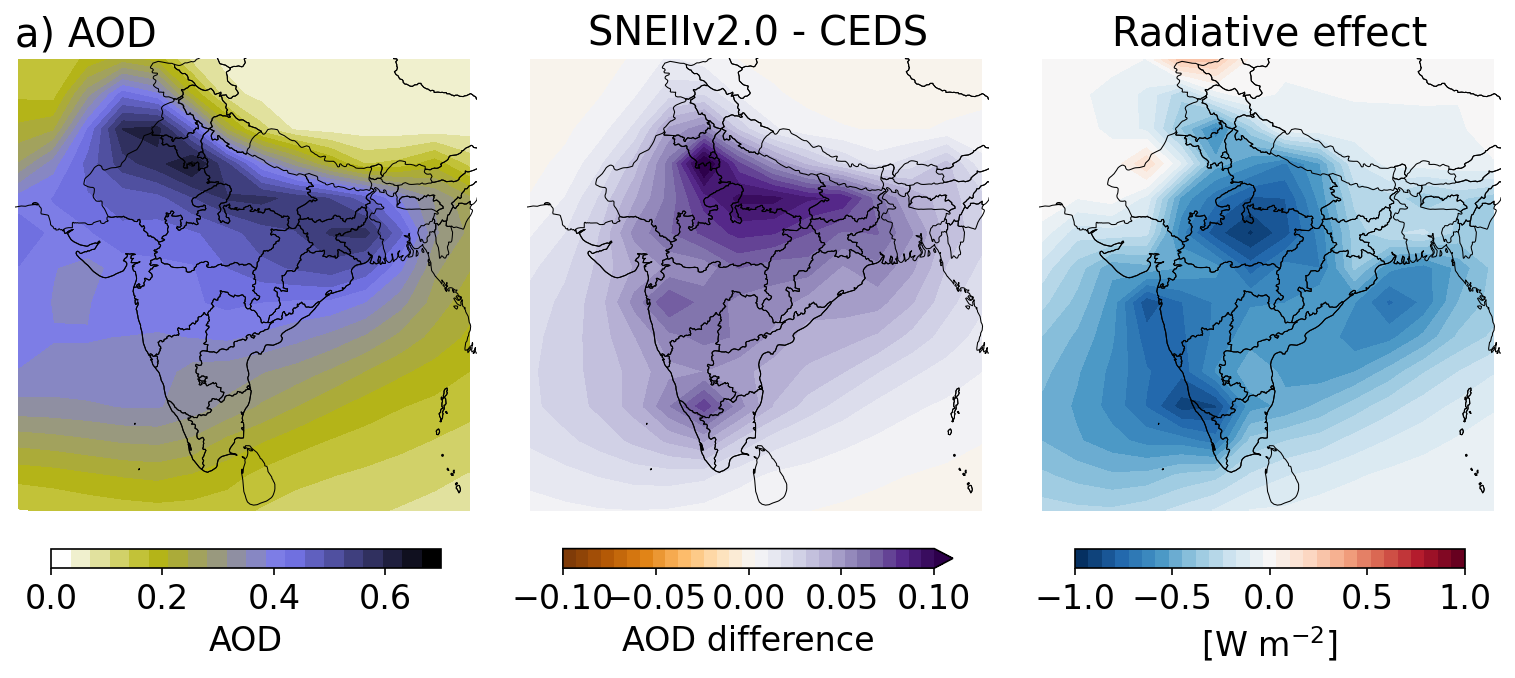

In [61]:
fig, axs = plt.subplots(1, 3, dpi=150, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(13, 5))


# Total column ozone
ax = axs[0]
fg = calcs['SNEII'].AOD.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(ax=ax,cmap=cmap_ol_pu_bk,
    vmax=0.7, vmin=0,
    levels=21, 
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'AOD',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(0,0.61,0.2))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
ax.set_title('')
ax.set_title(f"a) AOD", loc='left')
ax.axis("off") #remove frame around figure
ax.set_extent([65, 95, 5, 35], crs=ccrs.PlateCarree())


# Plot 2: Difference map tot column
ax = axs[1]
fg = calcs['diff'].AOD.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(ax=ax,cmap="PuOr",
    vmax=0.1, vmin=-0.1,
    levels=30, 
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )
cbar = fig.colorbar(fg,label= f'AOD difference',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(-0.1,0.11,0.05))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.axis("off") #remove frame around figure
ax.set_title('SNEIIv2.0 - CEDS')


ax = axs[2]
fg = calcs['diff'].net_RF.mean(dim='time').sel(lon=slice(65, 96), lat=slice(5, 35)).plot.contourf(ax=ax,cmap="RdBu_r",
    vmax=1, vmin=-1,
    levels=30, 
    xlim=(65,95),
    ylim=(5,35),add_colorbar=False
    )

cbar = fig.colorbar(fg,label= f'[W m$^{{-2}}$]',location='bottom',pad= 0.05,shrink=0.8,ticks=np.arange(-1,1.1,0.5))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
ax.coastlines(linewidth=0.5)  # cartopy function
ax.add_feature(cfeature.STATES,linewidth=0.5)
ax.set_title('Radiative effect')

#ax.add_feature(cfeature.OCEAN, zorder=4, edgecolor='k',linewidth=0.5,facecolor='w')
ax.axis("off") #remove frame around figure


#plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(f'{outfile}Fig4_AOD.pdf',format='pdf',bbox_inches='tight')